In [2]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import FancyArrowPatch

In [3]:
class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [4]:
from matplotlib.patches import ArrowStyle

In [5]:
import pdb

In [6]:
from scipy.ndimage import gaussian_filter1d

In [67]:
# Generate a trajectory in 3D space 
def gen_trajectory(end, sigma, nt):
    end = np.array(end)

    # Produce the line between start and end, and then add noise perpendicular to it
    t = np.linspace(0, 1, nt)
    xt = np.linspace(0, end[0], nt)
    yt = np.linspace(0, end[1], nt)
    zt = np.linspace(0, end[2], nt)

    d = np.hstack([xt[:, np.newaxis], yt[:, np.newaxis], zt[:, np.newaxis]])

    y = np.zeros((nt, 3))
    for i in range(1, nt):
        # Each timestep, advance towards the target

        # In the perpendicular direction

        noise = np.random.normal(scale=sigma, size=(3,))
        # Project onto the plane perpendicular to the straight line
        noise_perp = noise - np.dot(noise, end)/np.dot(end, end) * end

        y[i, :] = y[i - 1, :] + noise_perp + d[i, :] - d[i - 1, :]

    # Smooth
    y = gaussian_filter1d(y, sigma=1.5, axis=1)

    # Rescale to have the desired norm

    y *= np.linalg.norm(end)/np.linalg.norm(y[-1, :])    


    return t, y

In [106]:
def gen_regulated_trajectory(end1, end2, sigma, nt):
    end1 = np.array(end1)
    end2 = np.array(end2)

    # First half of the trajectory
    t = np.linspace(0, 1, nt)
    xt = np.linspace(0, end1[0], nt)
    yt = np.linspace(0, end1[1], nt)
    zt = 0.5 * np.power(1 - t, 2) + (- 0.5 - end1[2]) * (1 - t) + end1[2]

    d = np.hstack([xt[:, np.newaxis], yt[:, np.newaxis], zt[:, np.newaxis]])

    y1 = np.zeros((nt, 3))
    for i in range(1, nt):
        # Each timestep, advance towards the target

        # In the perpendicular direction

        noise = np.random.normal(scale=sigma, size=(3,))
        # Project onto the plane perpendicular to the tangent of the parabola
        dd = (d[i, :] - d[i - 1, :])
        noise_perp = noise - np.dot(noise, dd)/np.dot(dd, dd) * dd

        y1[i, :] = y1[i - 1, :] + noise_perp + dd

    # Smooth
    y1 = gaussian_filter1d(y1, sigma=1.5, axis=1)

    # Rescale to have the desired norm

    y1 *= np.linalg.norm(end1)/np.linalg.norm(y1[-1, :])    

    # Second half
    nt = int(nt//2)
    t = np.linspace(0, 1, nt)
    xt = (1 - t) * end1[0] + t * end2[0]
    yt = (1 - t) * end2[1] + t * end2[1]
    zt = 0.5 * np.power(1 - t, 2) + (end1[2] - 0.5 - end2[2]) * (1 - t) + end2[2]

    d = np.hstack([xt[:, np.newaxis], yt[:, np.newaxis], zt[:, np.newaxis]])

    y2 = np.zeros((nt, 3))
    y2[0, :] = end1
    for i in range(1, nt):
        # Each timestep, advance towards the target

        # In the perpendicular direction

        noise = np.random.normal(scale=sigma, size=(3,))
        # Project onto the plane perpendicular to the tangent of the parabola
        dd = (d[i, :] - d[i - 1, :])
        noise_perp = noise - np.dot(noise, dd)/np.dot(dd, dd) * dd

        y2[i, :] = y2[i - 1, :] + noise_perp + dd

    # Smooth
    y2 = gaussian_filter1d(y2, sigma=1.5, axis=1)

    # Rescale to have the desired norm

    y2 *= np.linalg.norm(end2)/np.linalg.norm(y2[-1, :])    

    y = np.vstack([y1, y2])

    return t, y

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if __name__ == '__main__':
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if __name__ == '__main__':


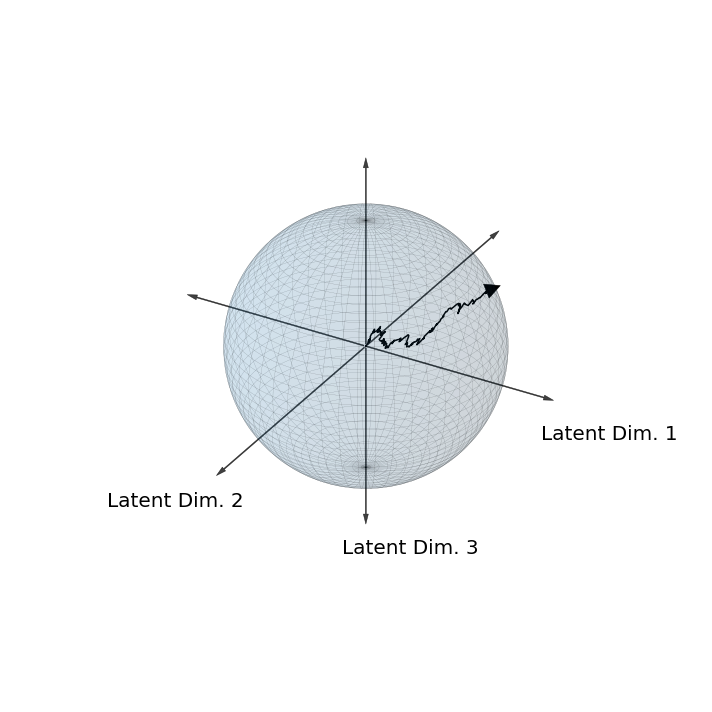

In [84]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 1))
# Draw centered axes
labels = ['Latent Dim 1', 'Latent Dim 2', 'Latent Dim 3']


kwargs = {'color':'k', 'alpha':0.75, 'lw':0.5, 'arrowstyle':ArrowStyle('simple', head_length=2, head_width=1), 'mutation_scale':5}


# x, y, z axes
a = Arrow3D([-0.01, 0.75], [0, 0], [0, 0], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, -0.75], [0, 0], [0, 0], **kwargs)
ax.add_artist(a)


a = Arrow3D([0, 0], [0, -1], [0, 0], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, 0], [0, 1], [0, 0], **kwargs)
ax.add_artist(a)


a = Arrow3D([0, 0], [0, 0], [0, 0.75], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, 0], [0, 0], [0, -0.75], **kwargs)
ax.add_artist(a)

ax.text(0.75, -0.1, -0.1, 'Latent Dim. 1', fontsize=20)
ax.text(-0.3, -1.2, -0.1, 'Latent Dim. 2', fontsize=20)
ax.text(-0.1, 0, -0.9, 'Latent Dim. 3', fontsize=20)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# Hide box axesa

ax._axis3don = False

u, v = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]
r = 0.5
x = r*np.cos(u)*np.sin(v)
y = r*np.sin(u)*np.sin(v)
z = r*np.cos(v)


ax.plot_surface(x, y, z, alpha=0.1, edgecolors=(0, 0, 0, 0.2), linewidth=0.2)

# Noisy open loop trajectory
theta = np.pi/4
phi = np.pi/2
end = (r * np.cos(theta) * np.sin(phi), r * np.sin(theta) * np.sin(phi), r * np.cos(phi))
t, yt = gen_trajectory(end, 0.01, 200)

ax.plot(yt[:, 0], yt[:, 1], yt[:, 2], color='k')
kwargs = {'color':'k', 'alpha':1, 'lw':0.5, 'arrowstyle':ArrowStyle('simple', head_length=15, head_width=15), 'mutation_scale':1}

# Plot an arrow that points along the radial direction
r = np.linalg.norm(yt[-1])
phi = np.arccos(yt[-1, 2]/r)
theta = np.arctan(yt[-1, 1]/yt[-1, 0])
r *= 1.05
true_end = r * np.cos(theta) * np.sin(phi), r * np.sin(theta) * np.sin(phi), r * np.cos(phi)
a = Arrow3D([yt[-2, 0], true_end[0]], [yt[-2, 1], true_end[1]], [yt[-2, 2], true_end[2]], **kwargs)


ax.add_artist(a)
# Hide everything else
# Hide axes ticks
ax.set_xlim(np.array([-1,1])*.7)
ax.set_ylim(np.array([-1,1])*.7)
ax.set_zlim(np.array([-1,1])*.7)

# 


fig.tight_layout()
fig.savefig('openloopcontrol.pdf', bbox_inches='tight', pad_inches=0)

/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if __name__ == '__main__':
/home/akumar/anaconda3/envs/dyn/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  if __name__ == '__main__':


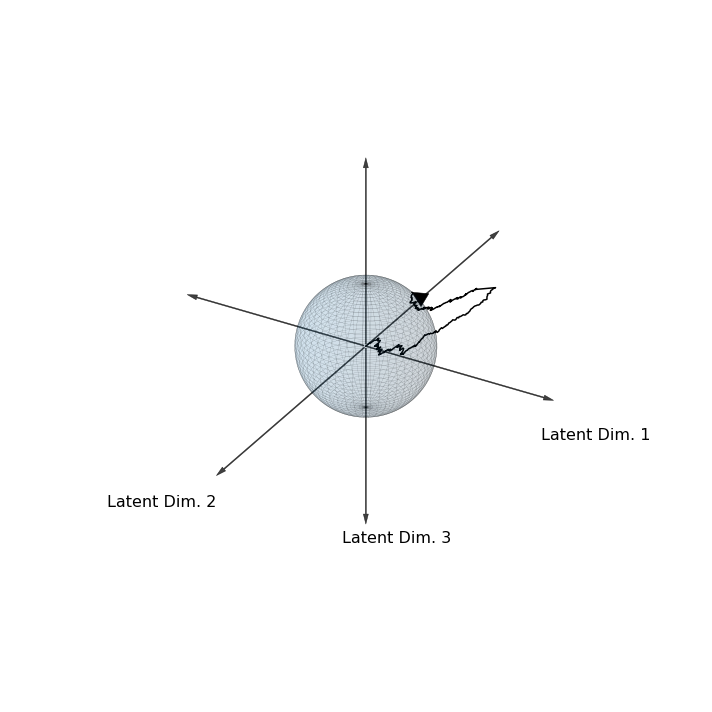

In [112]:
# Plot a noisy trajectory from the origin to the surface
# For regulation, plot a noisy trajectory that overshoot and then reverts back to the bounded region
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect((1, 1, 1))
# Draw centered axes
labels = ['Latent Dim 1', 'Latent Dim 2', 'Latent Dim 3']


kwargs = {'color':'k', 'alpha':0.75, 'lw':0.5, 'arrowstyle':ArrowStyle('simple', head_length=2, head_width=1), 'mutation_scale':5}


# x, y, z axes
a = Arrow3D([-0.01, 0.75], [0, 0], [0, 0], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, -0.75], [0, 0], [0, 0], **kwargs)
ax.add_artist(a)


a = Arrow3D([0, 0], [0, -1], [0, 0], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, 0], [0, 1], [0, 0], **kwargs)
ax.add_artist(a)


a = Arrow3D([0, 0], [0, 0], [0, 0.75], **kwargs)
ax.add_artist(a)

a = Arrow3D([0, 0], [0, 0], [0, -0.75], **kwargs)
ax.add_artist(a)

ax.text(0.75, -0.1, -0.1, 'Latent Dim. 1', fontsize=16)
ax.text(-0.3, -1.2, -0.1, 'Latent Dim. 2', fontsize=16)
ax.text(-0.1, 0, -0.85, 'Latent Dim. 3', fontsize=16)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# Hide box axesa

ax._axis3don = False

u, v = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]
r = 0.25
x = r*np.cos(u)*np.sin(v)
y = r*np.sin(u)*np.sin(v)
z = r*np.cos(v)


ax.plot_surface(x, y, z, alpha=0.1, edgecolors=(0, 0, 0, 0.2), linewidth=0.2)

# Regulated closed loop trajectory
theta = np.pi/4
phi = np.pi/2
r1 = 0.5
end1 = (r1 * np.cos(theta) * np.sin(phi), r1 * np.sin(theta) * np.sin(phi), r1 * np.cos(phi))


theta = 0
phi = 0
r2 = r
end2 = (r2 * np.cos(theta) * np.sin(phi), r2 * np.sin(theta) * np.sin(phi), r2 * np.cos(phi))

t, yt = gen_regulated_trajectory(end1, end2, 0.005, 200)
ax.plot(yt[:, 0], yt[:, 1], yt[:, 2], 'k')


kwargs = {'color':'k', 'alpha':1, 'lw':0.5, 'arrowstyle':ArrowStyle('simple', head_length=15, head_width=15), 'mutation_scale':1}
a = Arrow3D([yt[-2, 0], yt[-1, 0]], [yt[-2, 1], yt[-1, 1]], [yt[-2, 2], yt[-1, 2]], **kwargs)
ax.add_artist(a)


# Hide everything else
# Hide axes ticks
ax.set_xlim(np.array([-1,1])*.7)
ax.set_ylim(np.array([-1,1])*.7)
ax.set_zlim(np.array([-1,1])*.7)

fig.tight_layout()
fig.savefig('closedloopcontrol.pdf', bbox_inches='tight', pad_inches=0)

In [30]:
# Schematic input
from neurosim.models.ssr import StateSpaceRealization as SSR

In [46]:
A = 1/(2 * np.sqrt(5)) * np.random.normal(size=(5, 5))
C = np.zeros((1, 5))
C[0,  :] = 1
B = np.eye(A.shape[0])

ssr = SSR(A=A, B=0.05*B, C=C)

In [58]:
x = ssr.trajectory(200, burnoff=True)

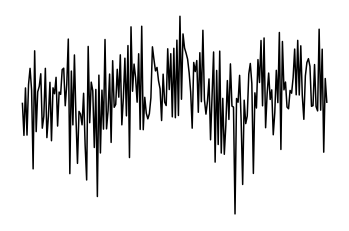

In [60]:
plt.plot(x, 'k')
plt.axis('off')
plt.savefig('input2.pdf',  bbox_inches='tight', pad_inches=0)